# Model Training
The main notebook to set up all things related to training our ML models.

## Import Libraries
Import all necessary libraries for training.

In [1]:
from __future__ import print_function, division
import gc
import matplotlib.pyplot as plt
import os
from PIL import Image
import torch
import torch.nn as nn
import torch.optim as optim
from torch.utils.data import Dataset
from torchvision import utils
import torchvision.transforms as transforms
from torch.autograd import Variable

## Import Models
Import all models (see `models/`).

In [2]:
import torch.nn as nn
from torchvision import datasets, models, transforms

from models.convbasic import ConvNeuralNet
from models.transferlearning import load_pretrained_model

## Import Dataset Class and Transforms
Used to help load in the images for heatmap generation

In [3]:
from utilities.dataset import ImageDataset
from utilities.transforms import data_transforms

## Helper Function to Plot Metrics
Plot training and test accuracies.

In [4]:
def plot_metrics(metric_set, metric_name, save_path):
    fig, ax = plt.subplots()
    ax.plot(metric_set)
    ax.set(xlabel='epochs', ylabel=metric_name,
        title='Training ' + metric_name)
    fig.savefig('graphs/' + save_path)

## Helper Function to Train Model
Train the model.

In [13]:
def train_model(transform, batch_size, epochs, weights_path, model_type, network, threshold, proportion):
    # Loading in initial training data
    print("Proportion of Training Data: " + str(proportion * 100) + "\n")
    print("Loading in training data...")
    train_data = ImageDataset("train", transform, proportion, "dalle", "stable-diffusion")
    trainloader = torch.utils.data.DataLoader(train_data, batch_size=batch_size,
                                            shuffle=True)
    print("Done loading in training data.\n")

    # Creating the CNN, loss function, and optimizer
    net = network
    if (torch.cuda.is_available()):
        net.to('cuda')
    criterion = nn.CrossEntropyLoss()
    optimizer = optim.SGD(net.parameters(), lr=0.001, momentum=0.9)

    # Train for number of epochs
    print("Start Training!\n")
    training_losses = []
    training_accuracies = []
    
    # Iterate for max epochs or until convergence
    curr_epoch = 0
    while (curr_epoch < 15 and ((curr_epoch < 8) or (abs(training_losses[-1] - training_losses[-2]) >= threshold))):
        # Reset the loss and correct
        print("Epoch " + str(curr_epoch + 1))
        running_loss = 0.0
        correct = 0

        # Iterate through each batch
        for i, data in enumerate(trainloader, 0):
            # Get batch data and zero parameter gradients
            inputs, labels, img_names = data
            inputs_cuda, labels_cuda = inputs.cuda(), labels.cuda()
            optimizer.zero_grad()

            # Forward + Backward Propopagation
            outputs = net(inputs_cuda)
            loss = criterion(outputs, labels_cuda)
            loss.backward()

            # Optimization Step
            optimizer.step()

            # Calculate accuracy and loss
            _, predicted = torch.max(outputs.cpu().data, 1)
            correct += (predicted == labels).float().sum()
            running_loss += outputs.cpu().shape[0] * loss.item()
        
        # Calculation of the accuracy and loss
        total_loss = running_loss / len(train_data)
        accuracy = 100 * correct / len(train_data)
        print("Loss = {}".format(total_loss))
        print("Accuracy = {}\n".format(accuracy))

        # Appending to the arrays to look at further visualization
        training_losses.append(total_loss)
        training_accuracies.append(accuracy)
        curr_epoch += 1

    # Saving trained model
    print("Finished Training!\n")
    torch.save(net.state_dict(), weights_path)

    # Graph out training loss and accuracy over time
    plot_metrics(training_losses, 'Loss', model_type + '_' + str(proportion) + '_training_loss.png')
    plot_metrics(training_accuracies, 'Accuracy', model_type + '_' + str(proportion) + '_training_accuracies.png')
    return training_losses[-1], training_accuracies[-1]

## Helper Function to Test the Model
Testing the model.

In [14]:
def test_model(transform, weights_path, batch_size, network, proportion):
    # Loading in initial test data
    print("\nLoading in test data...")
    test_data = ImageDataset("test", transform, proportion, "dalle", "stable-diffusion")
    testloader = torch.utils.data.DataLoader(test_data, batch_size=batch_size,
                                            shuffle=True)
    print("Done loading in test data.")

    # Test Loading
    dataiter = iter(testloader)
    images, labels, img_names = next(dataiter)

    # Loading in a new example of the neural net, and loading in the weights
    net = network
    if (torch.cuda.is_available()):
        net.to('cuda')
    net.load_state_dict(torch.load(weights_path))

    # Getting accuracy of the data
    correct = 0
    total = 0
    
    # No training = no gradients
    with torch.no_grad():
        for data in testloader:
            # Pass into network to calculate predictions
            images, labels, _ = data
            images_cuda, labels_cuda = images.cuda(), labels.cuda()
            outputs = net(images_cuda)

            # Calculate total number of correct predictions
            _, predicted = torch.max(outputs.cpu().data, 1)
            total += labels.size(0)
            correct += (predicted == labels).sum().item()
    
    # Print out accuracy!
    print('Accuracy of the network on the ' + str(len(test_data)) + ' test images: ' + str(100 * correct / total) + '%')
    return 100 * correct / total

## Main Function
Runs all of the necessary functions!

In [15]:
def main(model_type):
    # Map of all possible models
    models = {
        'ConvBasic': ConvNeuralNet(),
        'TransferLearning': load_pretrained_model()
    }
    model = models[model_type]    
  
    # Batch size, max epochs, and threshold for convergence
    batch_size = 200
    max_epochs = 15
    threshold = 0.005
    
    # Look at different proportions of data and train + test accs
    train_accs = []
    test_accs = []
    proportions = [0.5, 0.6, 0.7, 0.8, 0.9]
    
    # Train + test the data
    for prop in proportions:
        PATH = 'weights/' + model_type + '-' + str(prop) + '-nonpretrainedsdvsdalle.pth'
        training_loss, training_accuracy = train_model(transform=data_transforms[model_type], batch_size=batch_size, epochs=max_epochs, weights_path=PATH, model_type=model_type, network=model, threshold=threshold, proportion=prop)
        test_accuracy = test_model(data_transforms[model_type], PATH, batch_size, network=model, proportion=prop)
        
        # Update train and test accuracies
        train_accs.append(training_accuracy)
        test_accs.append(test_accuracy)
        
    return train_accs, test_accs

## Run all code!
Runs all of the code for Transfer Learning.

Proportion of Training Data: 50.0

Loading in training data...
Done loading in training data.

Start Training!

Epoch 1
Loss = 0.6753699374430387
Accuracy = 57.48959732055664

Epoch 2
Loss = 0.6474964100345659
Accuracy = 61.85852813720703

Epoch 3
Loss = 0.6262424170722909
Accuracy = 65.46463012695312

Epoch 4
Loss = 0.6157830746924496
Accuracy = 65.77669525146484

Epoch 5
Loss = 0.6074647738930257
Accuracy = 66.92094421386719

Epoch 6
Loss = 0.5972763907562182
Accuracy = 67.26768493652344

Epoch 7
Loss = 0.5976508313508371
Accuracy = 66.50485229492188

Epoch 8
Loss = 0.5762974713281851
Accuracy = 69.72954559326172

Epoch 9
Loss = 0.5637000882675182
Accuracy = 69.97225952148438

Epoch 10
Loss = 0.5569040344591445
Accuracy = 71.04715728759766

Epoch 11
Loss = 0.5448478805870024
Accuracy = 71.25520324707031

Epoch 12
Loss = 0.5356161170296795
Accuracy = 72.7808609008789

Epoch 13
Loss = 0.5123162816863781
Accuracy = 74.51456451416016

Epoch 14
Loss = 0.49965723493393516
Accuracy = 74.895

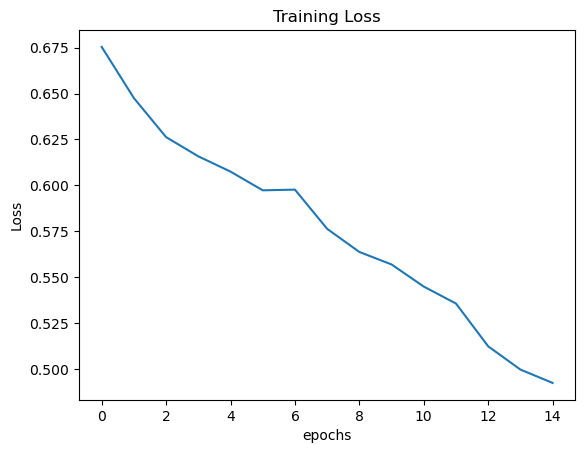

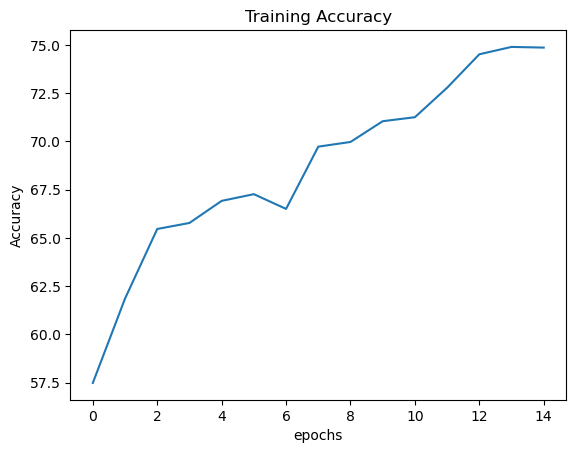

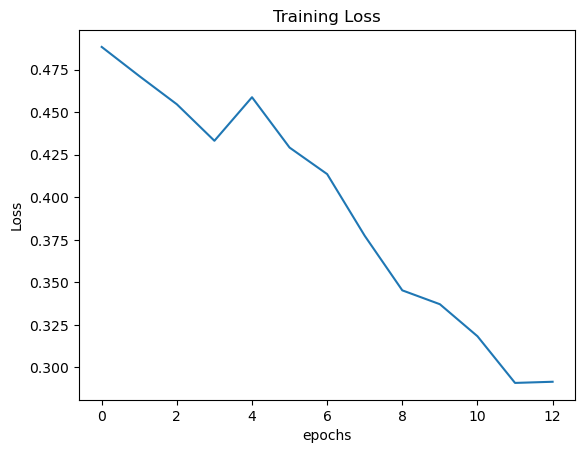

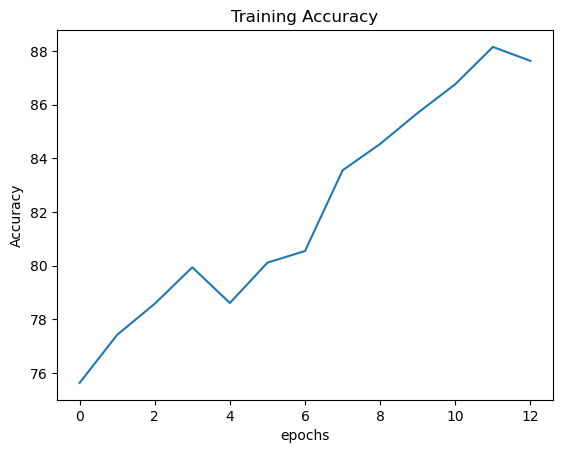

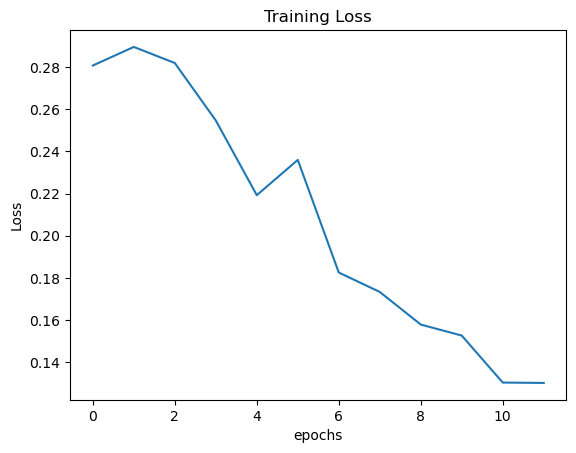

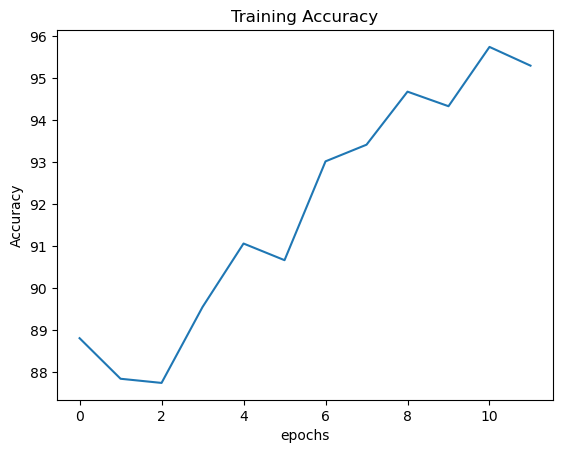

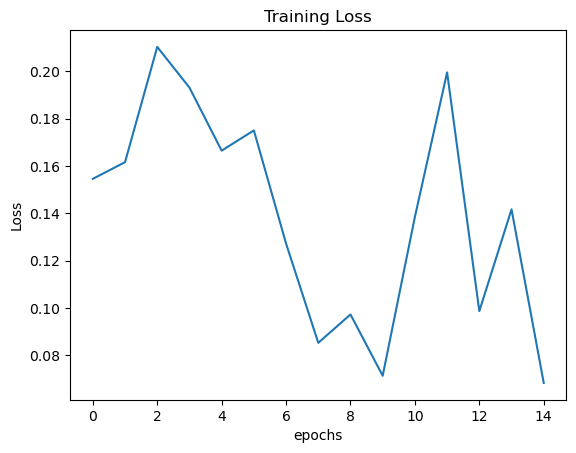

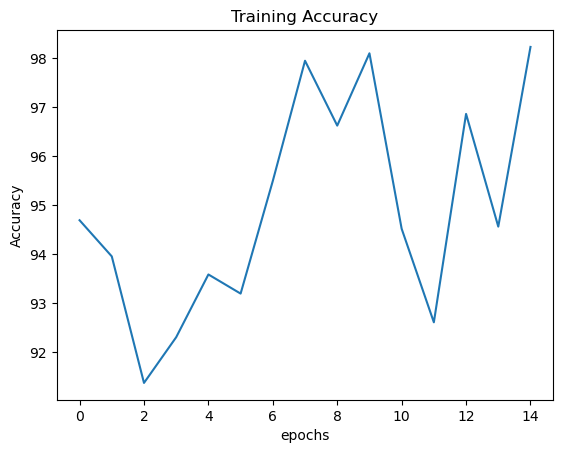

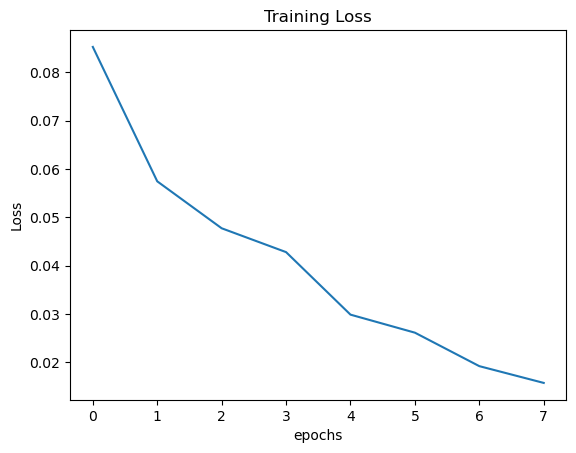

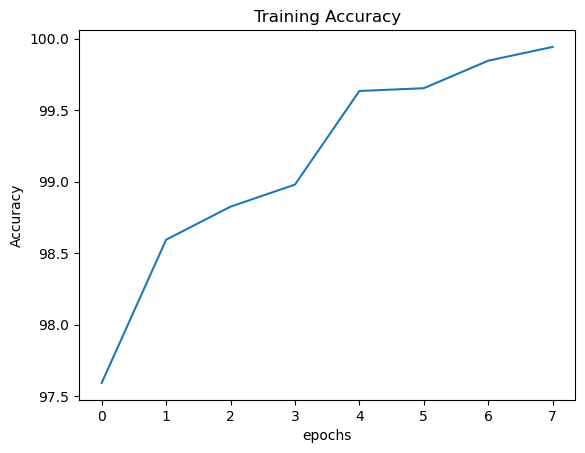

In [16]:
final_train = []
final_test = []

if __name__ == '__main__':
    train_accs, test_accs = main(model_type = "TransferLearning")
    
    final_train = train_accs
    final_test = test_accs